# Imports

In [45]:
pip install requests pandas numpy http.client tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [46]:
#Import
import requests
import pandas as pd
import numpy as np
import http.client, json
from urllib.parse import urlparse
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [4]:
def get_data(url):
    parsed_url = urlparse(url)
    conn = http.client.HTTPConnection(parsed_url.netloc)
    conn.request("GET", parsed_url.path)
    res = conn.getresponse()
    data = res.read()
    jsondata = json.loads(data.decode("utf-8"))
    return jsondata

def get_matchs_id(tournamentID = '17', seasonID = '52186'):
    matchs_id = []
    url_root = f"https://www.sofascore.com/api/v1/unique-tournament/{tournamentID}/season/{seasonID}/events/last/"
    hasNextPage = True
    i = 0

    while hasNextPage:
        present_url = url_root + str(i)
        data = get_data(present_url)
        for match in data['events']:
            matchs_id.append(match['id'])
        hasNextPage = data['hasNextPage'] #True or False
        i+=1 #access to nextpage
    
    return matchs_id

def get_date(matchID):
    data = get_data(f"https://www.sofascore.com/api/v1/event/{str(matchID)}")
    date = data['event']['startTimestamp']
    return date

In [5]:
matchs_id = get_matchs_id()

In [6]:
# Construct the forward players structured dataset
forward_players = {}

for id in tqdm(matchs_id):
    data = get_data(f"https://www.sofascore.com/api/v1/event/{id}/lineups")
    for team in ['home', 'away']:
        for player in data[team]['players']:
            
            if player['player']['position'] == 'F': #on ne considère que les attaquants

                key = player['player']['name']
                value = player['statistics']
                value['date'] = get_date(id) #dater les matchs
    
                if key in forward_players:
                    forward_players[key].append(value)
                else:
                    forward_players[key] = []
                    forward_players[key].append(value)



100%|██████████| 380/380 [00:47<00:00,  7.92it/s]


In [8]:
players_name = list(forward_players.keys())
nb_games_played = []
for player in players_name:
    nb_games_played.append(len(forward_players[player]))

In [10]:
# Créer le DataFrame
df = pd.DataFrame({
    'player': players_name,
    'nb_games_played': nb_games_played
})

# Afficher le DataFrame
df.head()

,player,nb_games_played
0,Bryan Mbeumo,25
1,Ivan Toney,18
2,Keane Lewis-Potter,33
3,Yoane Wissa,34
4,Kevin Schade,11


In [18]:
df_sorted = df.sort_values(by='nb_games_played', ascending=False)
df_sorted.head()

,player,nb_games_played
31,Moussa Diaby,38
39,Danny Ings,38
21,Julián Álvarez,38
12,Zeki Amdouni,38
83,Edward Nketiah,38


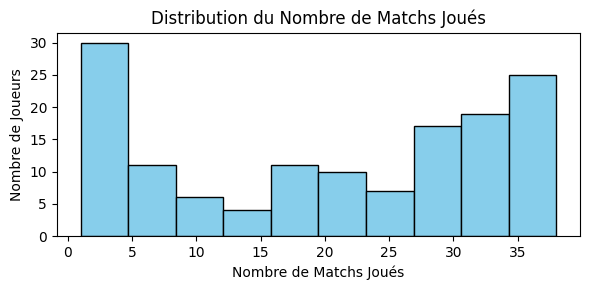

In [20]:
plt.figure(figsize=(6, 3))
plt.hist(df_sorted['nb_games_played'], color='skyblue', edgecolor='black')
plt.xlabel('Nombre de Matchs Joués')
plt.ylabel('Nombre de Joueurs')
plt.title('Distribution du Nombre de Matchs Joués')
plt.tight_layout()
plt.show()


In [26]:
df_top = df[df['nb_games_played']>30]
players_with_more_30_games = list(df_top['player'])
players_with_more_30_games

['Keane Lewis-Potter',
 'Yoane Wissa',
 'Neal Maupay',
 'Rodrigo Muniz',
 'Zeki Amdouni',
 'Jay Rodriguez',
 'Anthony Gordon',
 'Alexander Isak',
 'Miguel Almirón',
 'Erling Haaland',
 'Jérémy Doku',
 'Julián Álvarez',
 'Matheus Cunha',
 'Pablo Sarabia',
 'João Pedro',
 'Moussa Diaby',
 'Ollie Watkins',
 'Nicolas Jackson',
 'Danny Ings',
 'Divin Mubama',
 'Mohamed Salah',
 'Cody Gakpo',
 'Luis Díaz',
 'Darwin Núñez',
 'Heung-min Son',
 'Brennan Johnson',
 'Jean-Philippe Mateta',
 'Odsonne Édouard',
 'Jordan Ayew',
 'Dominic Solanke',
 'Abdoulaye Doucouré',
 'Dominic Calvert-Lewin',
 'Youssef Chermiti',
 'Beto',
 'Cameron Archer',
 'Carlton Morris',
 'Tahith Chong',
 'Cauley Woodrow',
 'Chris Wood',
 'Bukayo Saka',
 'Kai Havertz',
 'Leandro Trossard',
 'Gabriel Martinelli',
 'Edward Nketiah']

In [28]:
forward_players = {player : forward_players[player] for player in players_with_more_30_games}
len(forward_players)

44

In [30]:
# Get all features available
features = set()
for player, statistics in forward_players.items():
    for stat in statistics:
        features.update(stat.keys())
features

{'accurateCross',
 'accurateLongBalls',
 'accuratePass',
 'aerialLost',
 'aerialWon',
 'bigChanceCreated',
 'bigChanceMissed',
 'blockedScoringAttempt',
 'challengeLost',
 'clearanceOffLine',
 'date',
 'dispossessed',
 'duelLost',
 'duelWon',
 'errorLeadToAGoal',
 'errorLeadToAShot',
 'expectedAssists',
 'expectedGoals',
 'fouls',
 'goalAssist',
 'goals',
 'hitWoodwork',
 'interceptionWon',
 'keyPass',
 'minutesPlayed',
 'onTargetScoringAttempt',
 'outfielderBlock',
 'ownGoals',
 'penaltyConceded',
 'penaltyMiss',
 'penaltyWon',
 'possessionLostCtrl',
 'rating',
 'ratingVersions',
 'shotOffTarget',
 'totalClearance',
 'totalContest',
 'totalCross',
 'totalLongBalls',
 'totalOffside',
 'totalPass',
 'totalTackle',
 'touches',
 'wasFouled',
 'wonContest'}

In [32]:
selected_features = [
 'accuratePass',
 'bigChanceCreated',
 'bigChanceMissed',
 'date',
 'duelLost',
 'duelWon',
 'expectedAssists',
 'expectedGoals',
 'goalAssist',
 'goals',
 'minutesPlayed',
 'onTargetScoringAttempt',
 'rating',
 'shotOffTarget',
 'totalPass'
 ]

In [ ]:
def data_cleaning(dataset : dict, features : list):
    output = {}
    for player, matchs in dataset.items()
        output_matchs_list = []
        for match in matchs:
            output_match = {}
            if 


In [38]:
player = list(forward_players.keys())[0]
matchs = forward_players[player]
df = pd.DataFrame(matchs)
df = df.reindex(columns=selected_features).fillna(0)
df.head()


,accuratePass,bigChanceCreated,bigChanceMissed,date,duelLost,duelWon,expectedAssists,expectedGoals,goalAssist,goals,minutesPlayed,onTargetScoringAttempt,rating,shotOffTarget,totalPass
0,11.0,0.0,2.0,1714831200,5.0,3.0,0.013265,0.4515,0.0,0.0,66.0,2.0,6.1,0.0,14.0
1,14.0,0.0,1.0,1715436000,5.0,3.0,0.045030,0.1494,0.0,0.0,63.0,2.0,6.7,0.0,21.0
2,0.0,0.0,0.0,1716130800,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,0.0,2.0,1713621600,4.0,1.0,0.052051,1.2822,0.0,1.0,71.0,2.0,6.8,1.0,11.0
4,11.0,0.0,0.0,1714235400,3.0,2.0,0.007079,0.0768,0.0,0.0,22.0,1.0,6.8,0.0,14.0


In [37]:
df.sort_values(by='minutesPlayed', ascending=True)

,accuratePass,bigChanceCreated,bigChanceMissed,date,duelLost,duelWon,expectedAssists,expectedGoals,goalAssist,goals,minutesPlayed,onTargetScoringAttempt,rating,shotOffTarget,totalPass
2,0.0,0.0,0.0,1716130800,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1709391600,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,1691931600,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,1700933400,0.0,0.0,0.000000,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,3.0
30,2.0,0.0,0.0,1694881800,1.0,1.0,0.164383,0.0184,0.0,0.0,8.0,0.0,6.7,0.0,4.0
28,1.0,0.0,0.0,1693058400,1.0,1.0,0.000000,0.0000,0.0,0.0,10.0,0.0,6.5,0.0,3.0
8,5.0,0.0,0.0,1713016800,0.0,2.0,0.006084,0.0347,0.0,0.0,11.0,1.0,7.0,0.0,6.0
25,4.0,0.0,0.0,1701529200,0.0,2.0,0.000000,0.5627,0.0,0.0,12.0,1.0,7.4,2.0,4.0
14,4.0,0.0,0.0,1708457400,0.0,0.0,0.000000,0.0000,0.0,0.0,13.0,0.0,6.5,0.0,4.0
12,1.0,0.0,0.0,1707577200,5.0,1.0,0.000000,0.0000,0.0,0.0,14.0,0.0,6.1,0.0,1.0


In [39]:
df = df[df['minutesPlayed']>0]
df.head()

,accuratePass,bigChanceCreated,bigChanceMissed,date,duelLost,duelWon,expectedAssists,expectedGoals,goalAssist,goals,minutesPlayed,onTargetScoringAttempt,rating,shotOffTarget,totalPass
0,11.0,0.0,2.0,1714831200,5.0,3.0,0.013265,0.4515,0.0,0.0,66.0,2.0,6.1,0.0,14.0
1,14.0,0.0,1.0,1715436000,5.0,3.0,0.045030,0.1494,0.0,0.0,63.0,2.0,6.7,0.0,21.0
3,9.0,0.0,2.0,1713621600,4.0,1.0,0.052051,1.2822,0.0,1.0,71.0,2.0,6.8,1.0,11.0
4,11.0,0.0,0.0,1714235400,3.0,2.0,0.007079,0.0768,0.0,0.0,22.0,1.0,6.8,0.0,14.0
5,15.0,0.0,1.0,1711828800,3.0,6.0,0.084478,0.9800,0.0,0.0,87.0,3.0,7.2,2.0,22.0


In [50]:
df = df.sort_values(by='date', ascending=True)
df

,accuratePass,bigChanceCreated,bigChanceMissed,date,duelLost,duelWon,expectedAssists,expectedGoals,goalAssist,goals,minutesPlayed,onTargetScoringAttempt,rating,shotOffTarget,totalPass,cumulative_goals
32,2.0,0.0,1.0,1692453600,0.0,1.0,0.014518,0.2620,0.0,0.0,19.0,1.0,6.4,0.0,2.0,3.0
28,1.0,0.0,0.0,1693058400,1.0,1.0,0.000000,0.0000,0.0,0.0,10.0,0.0,6.5,0.0,3.0,3.0
29,7.0,0.0,1.0,1693663200,4.0,2.0,0.027909,0.4681,0.0,0.0,19.0,0.0,6.4,2.0,7.0,3.0
30,2.0,0.0,0.0,1694881800,1.0,1.0,0.164383,0.0184,0.0,0.0,8.0,0.0,6.7,0.0,4.0,3.0
26,10.0,0.0,1.0,1695486600,2.0,4.0,0.073768,0.1833,0.0,0.0,89.0,0.0,6.5,1.0,11.0,3.0
27,26.0,0.0,0.0,1696165200,6.0,4.0,0.013217,0.0272,0.0,0.0,75.0,0.0,6.8,1.0,31.0,3.0
24,0.0,0.0,0.0,1700933400,0.0,0.0,0.000000,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0
25,4.0,0.0,0.0,1701529200,0.0,2.0,0.000000,0.5627,0.0,0.0,12.0,1.0,7.4,2.0,4.0,3.0
21,5.0,0.0,0.0,1701891000,2.0,2.0,0.000000,0.0437,0.0,0.0,45.0,0.0,6.6,0.0,9.0,3.0
22,8.0,0.0,0.0,1702134000,3.0,3.0,0.055830,0.0000,0.0,0.0,66.0,0.0,6.6,0.0,12.0,3.0


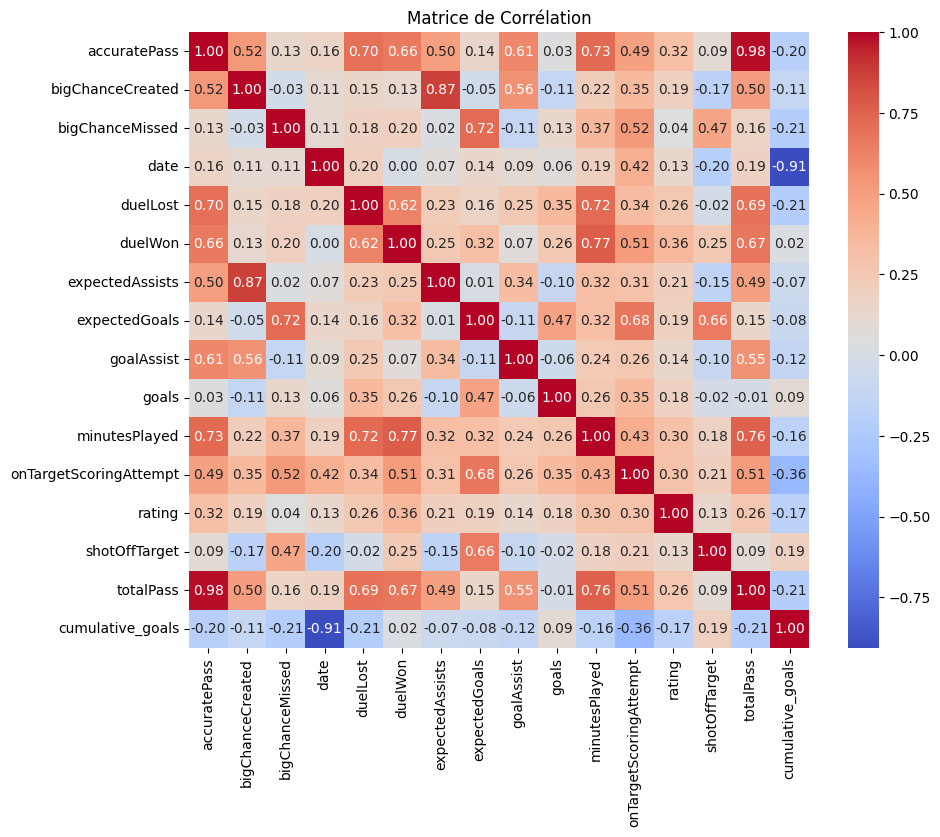

In [51]:
corr_matrix = df.corr()

# Afficher la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()

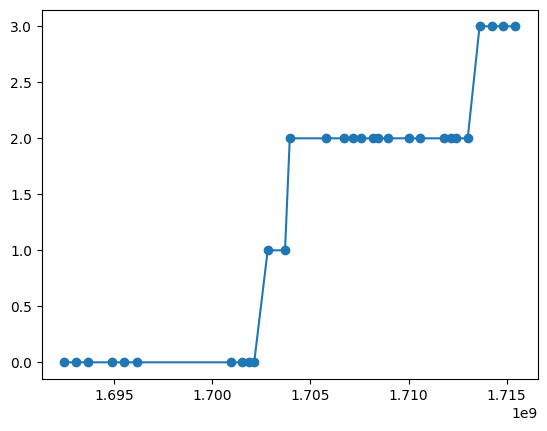

In [52]:
df['cumulative_goals'] = df['goals'].cumsum()

plt.plot(df['date'], df['cumulative_goals'], marker = 'o')